In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import featuretools as ft
%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET']]

# Pos_Cash Balance

In [5]:
pos_cash = help_tool.csv_download(r'Archive\home-credit-default-risk\POS_CASH_balance.csv')
#help_tool.first_look(pos_cash)

## Null values

When CNT_INSTALMENT is misisng, SK_DPD and SK_DPD_DEF have values 0

In [6]:
pos_cash[pos_cash['CNT_INSTALMENT'].isna() & pos_cash['CNT_INSTALMENT_FUTURE'].isna()][['SK_DPD', 'SK_DPD_DEF']].value_counts()

SK_DPD  SK_DPD_DEF
0       0             25974
Name: count, dtype: int64

Null values will be dropped

In [7]:
pos_cash = pos_cash[pos_cash['CNT_INSTALMENT'].notna() & pos_cash['CNT_INSTALMENT_FUTURE'].notna()]

## EDA
### Numerical Features

In [8]:
#help_visuals.distribution_check(pos_cash.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).sample(100000, random_state=42))

### Instalments
CNT_INSTALMENT_FUTURE and CNT_INSTALMENT_FUTURE have a dependency between each other, which is described by NAME_CONTRACT_STATUS

In [9]:
# g = sns.FacetGrid(pos_cash.sample(100000, random_state=42), col="NAME_CONTRACT_STATUS", col_wrap=4)
# g.map(sns.scatterplot, "CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE")
# g.set_titles(col_template="{col_name}", row_template="{row_name}")

# plt.show()

Ratio between SK_DPD and SK_DPD_DEF is not a constant when Status is Demand or Amortized debt. Which could sugest Ratio is depicting bad customers.

In [10]:
# g = sns.FacetGrid(pos_cash.sample(100000, random_state=42), col="NAME_CONTRACT_STATUS", col_wrap=4)
# g.map(sns.scatterplot, "SK_DPD", "SK_DPD_DEF")
# g.set_titles(col_template="{col_name}", row_template="{row_name}")

# plt.show()

### Categorical Features

NAME_CONTRACT_STATUS ca be separated into 2 columns for card activity and risk profile

In [11]:
# Apply the functions to create new columns
pos_cash['CARD_ACTIVITY'] = pos_cash['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_card_activity)
pos_cash['RISK_PROFILE'] = pos_cash['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_risk_profile)

pos_cash.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)

In [12]:
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,CARD_ACTIVITY,RISK_PROFILE
0,1803195,182943,-31,48.0,45.0,0,0,1,1
1,1715348,367990,-33,36.0,35.0,0,0,1,1
2,1784872,397406,-32,12.0,9.0,0,0,1,1
3,1903291,269225,-35,48.0,42.0,0,0,1,1
4,2341044,334279,-35,36.0,35.0,0,0,1,1


## Feature engineering

In [13]:
pos_cash[['RATIO_Term_Payed_Left', 'RATIO_DPD']] = duckdb.query("""
             SELECT 
             (CNT_INSTALMENT / CNT_INSTALMENT_FUTURE) AS RATIO_Term_Payed_Left,
             (SK_DPD / SK_DPD_DEF) AS RATIO_DPD
             FROM pos_cash
""").to_df()

In [14]:
# pos_cash['MONTHS_BALANCE'] = pos_cash['MONTHS_BALANCE'] + 96

## Previous Application and POS_CASH

In [15]:
pos_cash_simplified = pos_cash[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates().reset_index(drop=True)

In [16]:
es = ft.EntitySet(id='pos_cash_data')

es = es.add_dataframe(dataframe_name='pos_cash_simplified',
                      dataframe=pos_cash_simplified,
                      index='SK_ID_PREV')

es = es.add_dataframe(dataframe_name='pos_cash',
                      dataframe=pos_cash.drop(columns=['MONTHS_BALANCE', 'SK_ID_CURR']).reset_index(drop=True),
                      make_index=True,
                      index='index')

es = es.add_relationship(parent_dataframe_name='pos_cash_simplified',
                         parent_column_name='SK_ID_PREV',
                         child_dataframe_name='pos_cash',
                         child_column_name='SK_ID_PREV')

pos_cash_feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='pos_cash_simplified',
                                      agg_primitives=['mean', 'sum', 'count', 'std', 'max', 'min']
                                      )


pos_cash_feature_matrix = pos_cash_feature_matrix.reset_index()
pos_cash_feature_matrix.shape

c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function std at 0x000002F9718E8CC0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function max at 0x000002F9718E8180> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function min at 0x000002F9718E82C0> is currently using Series

(935435, 43)

In [17]:
# es = ft.EntitySet(id='pos_cash_data')

# es = es.add_dataframe(dataframe_name='previous_application',
#                       dataframe=previous_application,
#                       index='SK_ID_PREV')

# es = es.add_dataframe(dataframe_name='pos_cash',
#                       dataframe=pos_cash.drop(columns=['MONTHS_BALANCE', 'SK_ID_CURR', 'NAME_CONTRACT_STATUS']),
#                       make_index=True,
#                       index='index')

# es = es.add_relationship(parent_dataframe_name='previous_application',
#                          parent_column_name='SK_ID_PREV',
#                          child_dataframe_name='pos_cash',
#                          child_column_name='SK_ID_PREV')

# pos_cash_feature_matrix, feature_defs = ft.dfs(entityset=es,
#                                       target_dataframe_name='previous_application',
#                                       agg_primitives=['mean', 'sum', 'count', 'std', 'max', 'min']
#                                       )


# pos_cash_feature_matrix = pos_cash_feature_matrix.reset_index()
# pos_cash_feature_matrix.shape

In [18]:
pos_cash_feature_matrix = duckdb.query("""  
  SELECT A.*, B.Duration
  FROM pos_cash_feature_matrix A 
  LEFT JOIN (
    SELECT SK_ID_PREV, MAX(MONTHS_BALANCE) - MIN(MONTHS_BALANCE) AS Duration
    FROM pos_cash
    GROUP BY SK_ID_PREV
    ) B ON A.SK_ID_PREV = B.SK_ID_PREV
  """).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

No features with Zero vairiance

In [19]:
pos_cash_feature_matrix.drop(
    columns= help_tool.zero_variance_features(pos_cash_feature_matrix), 
    inplace = True
    )

In [20]:
pos_cash_feature_matrix.head()

,SK_ID_PREV,SK_ID_CURR,COUNT(pos_cash),MAX(pos_cash.CARD_ACTIVITY),MAX(pos_cash.CNT_INSTALMENT),MAX(pos_cash.CNT_INSTALMENT_FUTURE),MAX(pos_cash.RATIO_DPD),MAX(pos_cash.RATIO_Term_Payed_Left),MAX(pos_cash.RISK_PROFILE),MAX(pos_cash.SK_DPD),...,STD(pos_cash.SK_DPD_DEF),SUM(pos_cash.CARD_ACTIVITY),SUM(pos_cash.CNT_INSTALMENT),SUM(pos_cash.CNT_INSTALMENT_FUTURE),SUM(pos_cash.RATIO_DPD),SUM(pos_cash.RATIO_Term_Payed_Left),SUM(pos_cash.RISK_PROFILE),SUM(pos_cash.SK_DPD),SUM(pos_cash.SK_DPD_DEF),Duration
0,2119427,331456,6,2.0,6.0,6.0,NaN,1.666667,1.0,0.0,...,0.000000,7.0,35.0,20.0,0.0,8.450000,6.0,0.0,0.0,5
1,1055322,204968,13,2.0,12.0,12.0,NaN,10.000000,1.0,6.0,...,1.664101,14.0,156.0,78.0,0.0,31.782660,13.0,6.0,6.0,12
2,1768785,455527,13,2.0,12.0,12.0,1.0,12.000000,1.0,0.0,...,0.000000,14.0,156.0,78.0,1.0,27.444538,13.0,0.0,0.0,12
3,1783964,238215,8,2.0,6.0,6.0,NaN,6.000000,1.0,0.0,...,0.000000,9.0,48.0,21.0,0.0,21.000000,8.0,0.0,0.0,7
4,2208599,256471,12,2.0,12.0,12.0,NaN,5.000000,1.0,0.0,...,0.000000,13.0,143.0,77.0,0.0,31.586477,12.0,0.0,0.0,11


In [21]:
pos_cash_feature_matrix.shape

(935435, 44)

In [22]:
pos_cash_feature_matrix.to_csv(r'Archive\home-credit-default-risk\pos_cash_feature_matrix.csv')

In [5]:
pos_cash_feature_matrix = help_tool.csv_download(r'Archive\home-credit-default-risk\pos_cash_feature_matrix.csv').drop(columns='Unnamed: 0')

In [6]:
pos_cash_feature_matrix.head()

,SK_ID_PREV,SK_ID_CURR,COUNT(pos_cash),MAX(pos_cash.CARD_ACTIVITY),MAX(pos_cash.CNT_INSTALMENT),MAX(pos_cash.CNT_INSTALMENT_FUTURE),MAX(pos_cash.RATIO_DPD),MAX(pos_cash.RATIO_Term_Payed_Left),MAX(pos_cash.RISK_PROFILE),MAX(pos_cash.SK_DPD),...,STD(pos_cash.SK_DPD_DEF),SUM(pos_cash.CARD_ACTIVITY),SUM(pos_cash.CNT_INSTALMENT),SUM(pos_cash.CNT_INSTALMENT_FUTURE),SUM(pos_cash.RATIO_DPD),SUM(pos_cash.RATIO_Term_Payed_Left),SUM(pos_cash.RISK_PROFILE),SUM(pos_cash.SK_DPD),SUM(pos_cash.SK_DPD_DEF),Duration
0,2119427,331456,6,2.0,6.0,6.0,NaN,1.666667,1.0,0.0,...,0.000000,7.0,35.0,20.0,0.0,8.450000,6.0,0.0,0.0,5
1,1055322,204968,13,2.0,12.0,12.0,NaN,10.000000,1.0,6.0,...,1.664101,14.0,156.0,78.0,0.0,31.782660,13.0,6.0,6.0,12
2,1768785,455527,13,2.0,12.0,12.0,1.0,12.000000,1.0,0.0,...,0.000000,14.0,156.0,78.0,1.0,27.444538,13.0,0.0,0.0,12
3,1783964,238215,8,2.0,6.0,6.0,NaN,6.000000,1.0,0.0,...,0.000000,9.0,48.0,21.0,0.0,21.000000,8.0,0.0,0.0,7
4,2208599,256471,12,2.0,12.0,12.0,NaN,5.000000,1.0,0.0,...,0.000000,13.0,143.0,77.0,0.0,31.586477,12.0,0.0,0.0,11


Principal Component Analysis (PCA) - PCA assumes linear relationships among features, which may not capture complex, nonlinear structures.

In [7]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET']]

## Selecting featureswith Light XGB

In [8]:
app_pos_cash_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM pos_cash_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

Only 7% of target is positive

In [25]:
app_pos_cash_feature_matrix['TARGET'].value_counts() / app_pos_cash_feature_matrix['TARGET'].count()

TARGET
0    0.926306
1    0.073694
Name: count, dtype: float64

In [9]:
y = app_pos_cash_feature_matrix['TARGET']
X = app_pos_cash_feature_matrix.drop(columns=['TARGET', 'SK_ID_CURR'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [10]:
# Step 1: Drop unnecessary columns
filtered_matrix = pos_cash_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR'])

# Step 2: Compute the correlation matrix
correlation_matrix = filtered_matrix.corr()

# Step 3: Identify pairs of features with correlation greater than 0.9
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs < 1.0) & (high_corr_pairs >= 0.9)]

# Convert the series to a DataFrame for better readability
high_corr_pairs_df = high_corr_pairs.reset_index()
high_corr_pairs_df.columns = ['Feature1', 'Feature2', 'Correlation']

# Step 4: Rank features based on feature importance
# Assuming feature_importance is a DataFrame with 'feature' and 'importance' columns
# Join importance values with the feature pairs
high_corr_pairs_df = high_corr_pairs_df.merge(
    feature_importance, left_on='Feature1', right_on='feature').rename(columns={'importance': 'Importance1'})
high_corr_pairs_df = high_corr_pairs_df.merge(
    feature_importance, left_on='Feature2', right_on='feature').rename(columns={'importance': 'Importance2'})

# Drop the extra 'feature' columns from the merges
high_corr_pairs_df = high_corr_pairs_df.drop(columns=['feature_x', 'feature_y'])

# Step 5: Determine which feature to drop based on lower importance
high_corr_pairs_df['Feature_to_Drop'] = np.where(
    high_corr_pairs_df['Importance1'] < high_corr_pairs_df['Importance2'], 
    high_corr_pairs_df['Feature1'], 
    high_corr_pairs_df['Feature2']
)

# Identify unique features to drop
features_to_drop = high_corr_pairs_df['Feature_to_Drop'].unique()


In [11]:
app_pos_cash_feature_matrix.drop(columns=features_to_drop, inplace=True)

### 2nd Run

In [37]:
y = app_pos_cash_feature_matrix['TARGET']
X = app_pos_cash_feature_matrix.drop(columns=['TARGET', 'SK_ID_CURR', 'SK_ID_PREV'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [40]:
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ])

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Define the model
model = LGBMClassifier(**params, n_estimators=100)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [41]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision}")
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.2
accuracy: 0.9259534872086698
recall: 0.00033815199932369603
ROC AUC: 0.5541934962809731


In [30]:
# app_pos_cash_feature_matrix_filtered = app_pos_cash_feature_matrix[['SK_ID_PREV', 'TARGET'] + feature_importance.head(15)['feature'].to_list()]

In [31]:
# app_pos_cash_feature_matrix_filtered.fillna(-1, inplace=True)

In [32]:
# help_visuals.distribution_check(app_pos_cash_feature_matrix_filtered.drop(columns=['SK_ID_PREV']).sample(100000, random_state=42))

# Clustering with K means
## All features

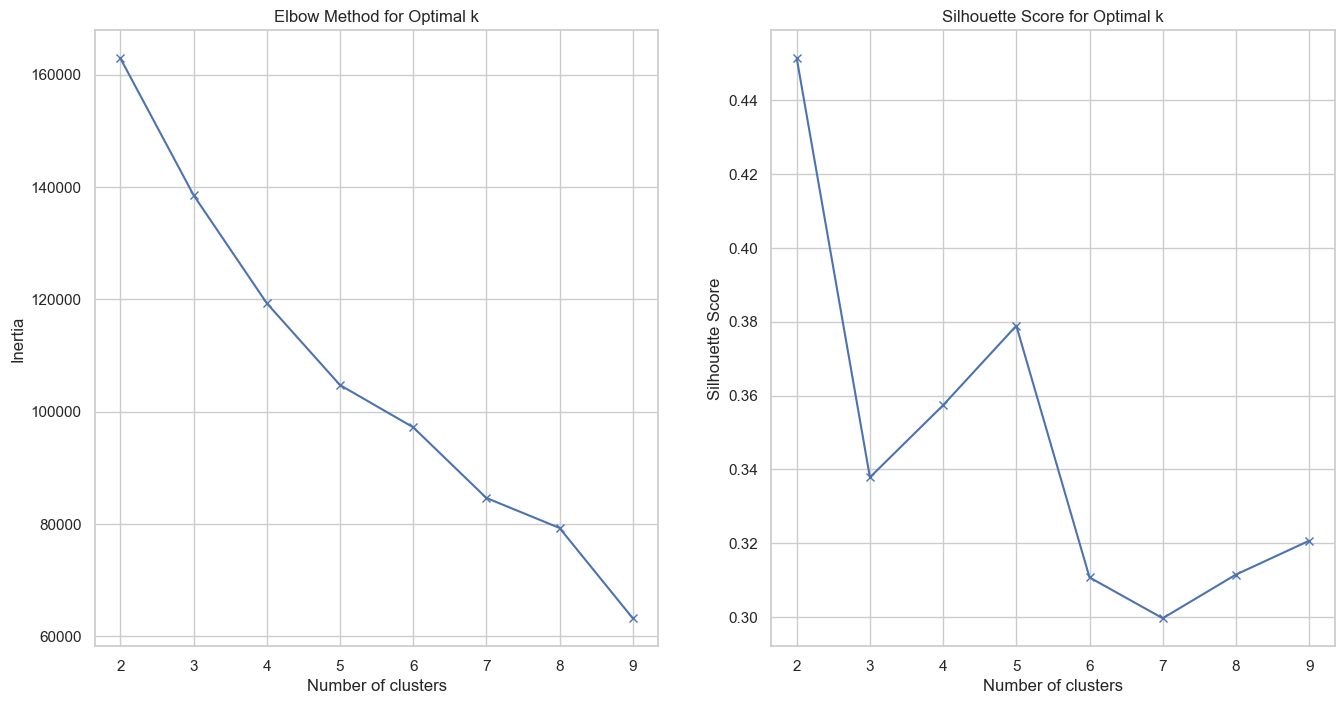

In [43]:
# Convert Pandas DataFrame to Polars DataFrame
polars_df = pl.from_pandas(pos_cash_feature_matrix[feature_importance.head(10)['feature'].to_list()].sample(20000, random_state=42).fillna(0))

# Convert Polars DataFrame to a numpy array for K-means
X = polars_df.to_numpy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the Elbow
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.show()

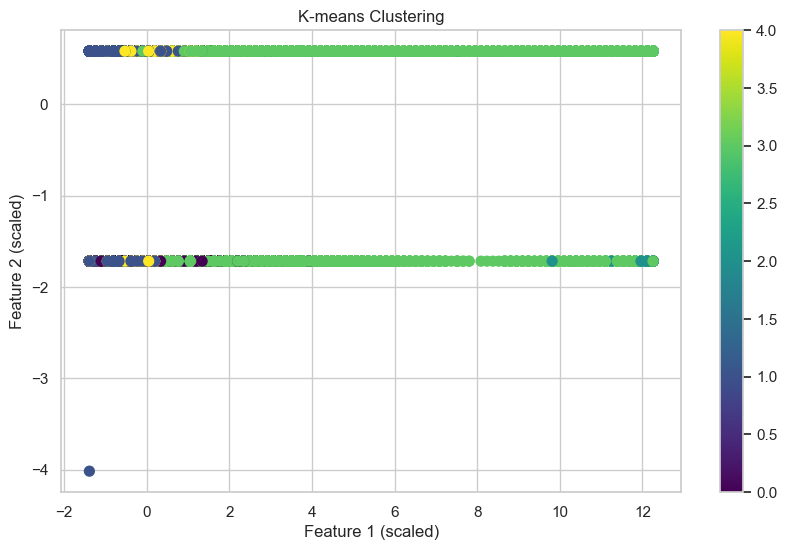

In [44]:
polars_df = pl.from_pandas(pos_cash_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).fillna(0))

# Convert Polars DataFrame to a numpy array for K-means
X = polars_df.to_numpy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X_scaled)

# Extract cluster labels
labels = kmeans.labels_

# Add cluster labels to the Polars DataFrame
polars_df = polars_df.with_columns(pl.Series(name="cluster", values=labels))

# print(polars_df)

# Visualize the clusters (if the data is 2D or can be reduced to 2D)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.title('K-means Clustering')
plt.colorbar()
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.show()

In [45]:
pos_cash_feature_matrix['Cluster_pos_cash'] = polars_df.to_pandas()['cluster']

In [46]:
pos_cash_feature_matrix.head()

,SK_ID_PREV,SK_ID_CURR,COUNT(pos_cash),MAX(pos_cash.CARD_ACTIVITY),MAX(pos_cash.CNT_INSTALMENT),MAX(pos_cash.CNT_INSTALMENT_FUTURE),MAX(pos_cash.RATIO_DPD),MAX(pos_cash.RATIO_Term_Payed_Left),MAX(pos_cash.RISK_PROFILE),MAX(pos_cash.SK_DPD),...,SUM(pos_cash.CARD_ACTIVITY),SUM(pos_cash.CNT_INSTALMENT),SUM(pos_cash.CNT_INSTALMENT_FUTURE),SUM(pos_cash.RATIO_DPD),SUM(pos_cash.RATIO_Term_Payed_Left),SUM(pos_cash.RISK_PROFILE),SUM(pos_cash.SK_DPD),SUM(pos_cash.SK_DPD_DEF),Duration,Cluster_pos_cash
0,2119427,331456,6,2.0,6.0,6.0,NaN,1.666667,1.0,0.0,...,7.0,35.0,20.0,0.0,8.450000,6.0,0.0,0.0,5,1
1,1055322,204968,13,2.0,12.0,12.0,NaN,10.000000,1.0,6.0,...,14.0,156.0,78.0,0.0,31.782660,13.0,6.0,6.0,12,4
2,1768785,455527,13,2.0,12.0,12.0,1.0,12.000000,1.0,0.0,...,14.0,156.0,78.0,1.0,27.444538,13.0,0.0,0.0,12,4
3,1783964,238215,8,2.0,6.0,6.0,NaN,6.000000,1.0,0.0,...,9.0,48.0,21.0,0.0,21.000000,8.0,0.0,0.0,7,1
4,2208599,256471,12,2.0,12.0,12.0,NaN,5.000000,1.0,0.0,...,13.0,143.0,77.0,0.0,31.586477,12.0,0.0,0.0,11,1


In [47]:
pos_cash_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM pos_cash_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

In [50]:
pos_cash_feature_matrix

,SK_ID_PREV,SK_ID_CURR,COUNT(pos_cash),MAX(pos_cash.CARD_ACTIVITY),MAX(pos_cash.CNT_INSTALMENT),MAX(pos_cash.CNT_INSTALMENT_FUTURE),MAX(pos_cash.RATIO_DPD),MAX(pos_cash.RATIO_Term_Payed_Left),MAX(pos_cash.RISK_PROFILE),MAX(pos_cash.SK_DPD),...,SUM(pos_cash.CNT_INSTALMENT),SUM(pos_cash.CNT_INSTALMENT_FUTURE),SUM(pos_cash.RATIO_DPD),SUM(pos_cash.RATIO_Term_Payed_Left),SUM(pos_cash.RISK_PROFILE),SUM(pos_cash.SK_DPD),SUM(pos_cash.SK_DPD_DEF),Duration,Cluster_pos_cash,TARGET
0,1004775,338909,6,2.0,6.0,6.0,NaN,1.846154,1.0,0.0,...,35.0,20.0,0.0,7.041252,6.0,0.0,0.0,5,1,0
1,2384110,286538,6,2.0,6.0,6.0,NaN,2.666667,1.0,0.0,...,35.0,20.0,0.0,10.678431,6.0,0.0,0.0,5,1,0
2,1488834,294351,9,1.0,10.0,10.0,1.0,6.000000,1.0,12.0,...,90.0,54.0,1.0,16.785714,9.0,12.0,0.0,8,1,0
3,1780514,259362,19,2.0,18.0,18.0,1.0,10.000000,1.0,0.0,...,342.0,171.0,1.0,58.519401,19.0,0.0,0.0,18,3,0
4,2244494,102760,7,1.0,48.0,48.0,NaN,2.000000,1.0,0.0,...,336.0,315.0,0.0,8.823814,7.0,0.0,0.0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799558,2192427,214774,13,2.0,12.0,12.0,NaN,3.000000,1.0,0.0,...,156.0,71.0,0.0,16.492949,13.0,0.0,0.0,12,1,0
799559,1419687,386209,7,2.0,12.0,12.0,NaN,2.666667,1.0,0.0,...,78.0,57.0,0.0,8.901282,7.0,0.0,0.0,6,1,0
799560,2001231,267232,5,2.0,4.0,4.0,NaN,3.000000,1.0,0.0,...,20.0,10.0,0.0,7.800000,5.0,0.0,0.0,4,1,0
799561,2549632,310966,4,2.0,60.0,60.0,NaN,1.714286,1.0,0.0,...,183.0,177.0,0.0,4.997499,4.0,0.0,0.0,3,3,0


In [55]:
pos_cash_feature_matrix[['TARGET', 'Cluster_pos_cash',]].value_counts() / pos_cash_feature_matrix['TARGET'].count() * 100

TARGET  Cluster_pos_cash
0       1                   51.616320
        4                   22.101698
        3                   14.099327
        0                    4.545233
1       1                    3.960288
        4                    1.732947
        3                    1.194027
        0                    0.452747
0       2                    0.268021
1       2                    0.029391
Name: count, dtype: float64

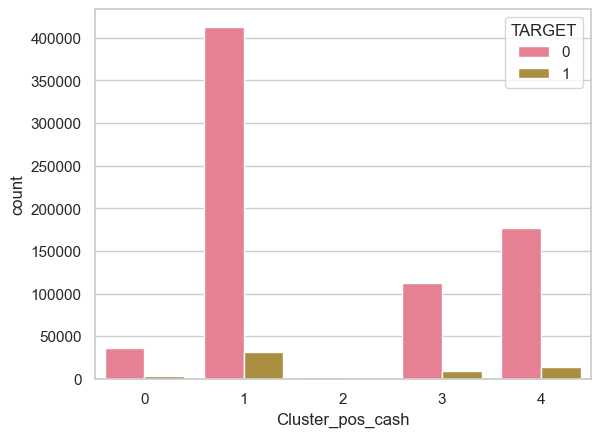

In [53]:
sns.countplot(data=pos_cash_feature_matrix, x='Cluster_pos_cash', hue='TARGET')
plt.show()

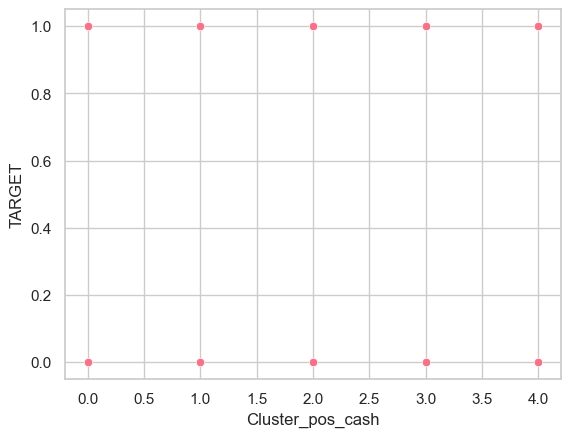

In [52]:
sns.scatterplot(data=pos_cash_feature_matrix, x='Cluster_pos_cash', y='TARGET')
plt.show()

## Filtered features

In [14]:
sorted_pos_cash_feature_matrix = app_pos_cash_feature_matrix[
    ['SK_ID_PREV', 'SK_ID_CURR'] + 
    
    feature_importance.head(10)['feature'].to_list()]

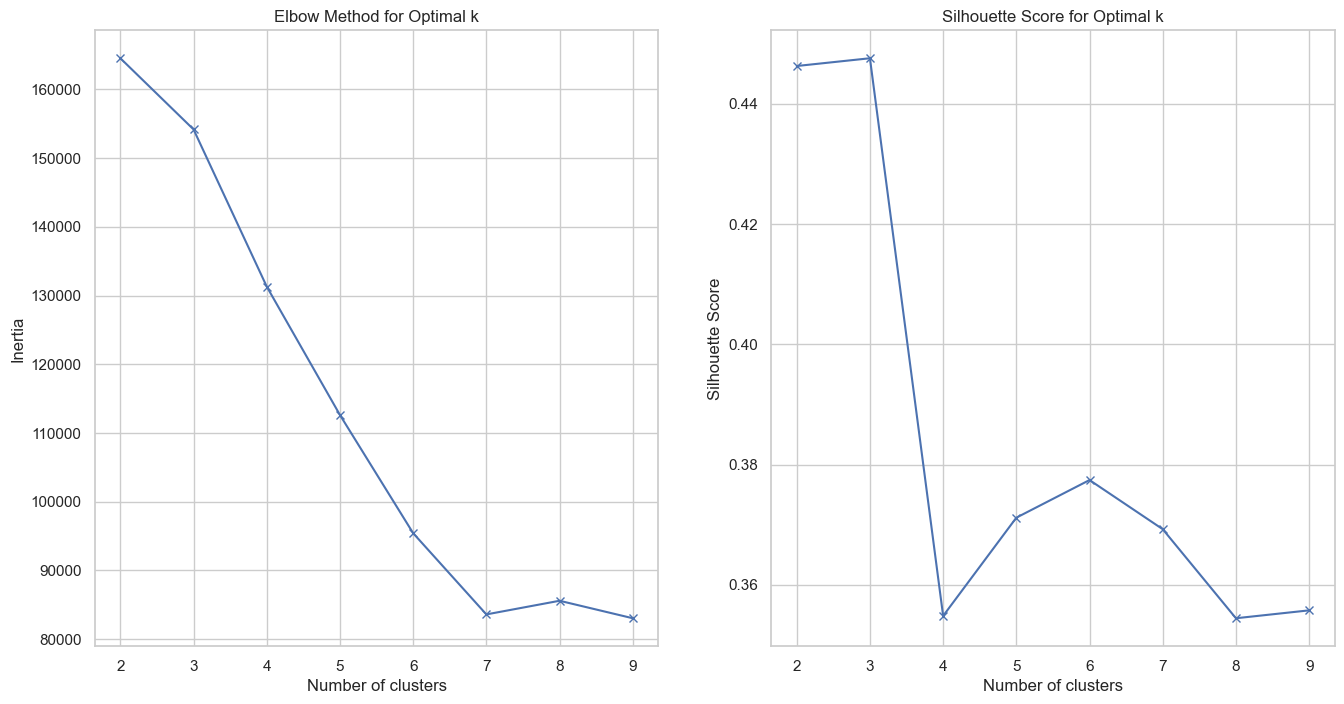

In [16]:
# Convert Pandas DataFrame to Polars DataFrame
polars_df = pl.from_pandas(sorted_pos_cash_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).sample(20000, random_state=42).fillna(-1))

# Convert Polars DataFrame to a numpy array for K-means
X = polars_df.to_numpy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the Elbow
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.show()

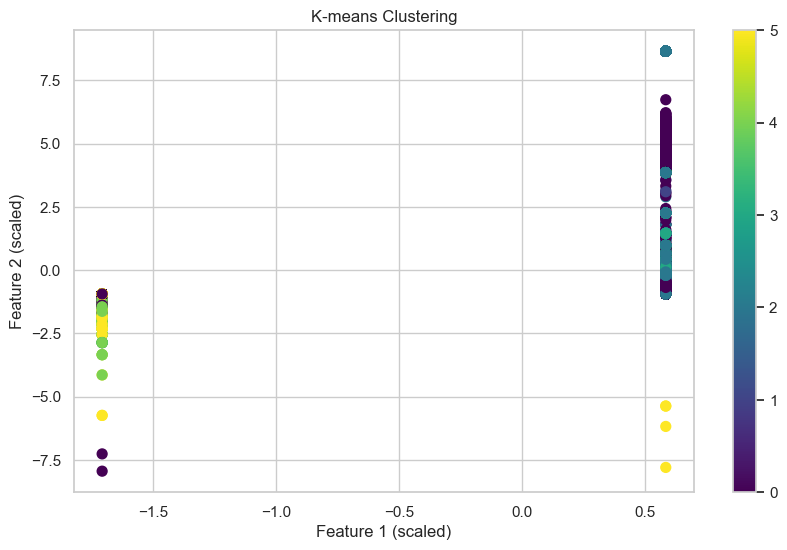

In [17]:
polars_df = pl.from_pandas(app_pos_cash_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']).fillna(-1))

# Convert Polars DataFrame to a numpy array for K-means
X = polars_df.to_numpy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X_scaled)

# Extract cluster labels
labels = kmeans.labels_

# Add cluster labels to the Polars DataFrame
polars_df = polars_df.with_columns(pl.Series(name="cluster", values=labels))

# print(polars_df)

# Visualize the clusters (if the data is 2D or can be reduced to 2D)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.title('K-means Clustering')
plt.colorbar()
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.show()

In [18]:
polars_df.head()

MAX(pos_cash.CARD_ACTIVITY),MEAN(pos_cash.CARD_ACTIVITY),MEAN(pos_cash.CNT_INSTALMENT_FUTURE),MEAN(pos_cash.RATIO_Term_Payed_Left),MEAN(pos_cash.RISK_PROFILE),MEAN(pos_cash.SK_DPD),MEAN(pos_cash.SK_DPD_DEF),MIN(pos_cash.CARD_ACTIVITY),MIN(pos_cash.CNT_INSTALMENT),MIN(pos_cash.CNT_INSTALMENT_FUTURE),MIN(pos_cash.RATIO_Term_Payed_Left),MIN(pos_cash.RISK_PROFILE),MIN(pos_cash.SK_DPD),MIN(pos_cash.SK_DPD_DEF),STD(pos_cash.CNT_INSTALMENT),STD(pos_cash.CNT_INSTALMENT_FUTURE),STD(pos_cash.RATIO_DPD),STD(pos_cash.RATIO_Term_Payed_Left),STD(pos_cash.RISK_PROFILE),SUM(pos_cash.CARD_ACTIVITY),SUM(pos_cash.CNT_INSTALMENT),SUM(pos_cash.RATIO_Term_Payed_Left),cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2.0,1.041667,11.5,2.343044,1.0,0.0,0.0,1.0,24.0,0.0,1.0,1.0,0.0,0.0,0.0,7.071068,-1.0,1.446339,0.0,25.0,576.0,51.546968,0
2.0,1.125,3.25,1.611905,1.0,0.0,0.0,1.0,6.0,0.0,1.2,1.0,0.0,0.0,0.0,2.434866,-1.0,0.440193,0.0,9.0,48.0,11.283333,2
2.0,1.071429,5.857143,3.889229,1.0,0.0,0.0,1.0,12.0,0.0,1.0,1.0,0.0,0.0,0.0,4.32981,-1.0,6.297782,0.0,15.0,168.0,50.559978,2
2.0,1.076923,6.0,2.644896,1.0,0.0,0.0,1.0,12.0,0.0,1.0,1.0,0.0,0.0,0.0,3.89444,-1.0,2.575822,0.0,14.0,156.0,23.804067,2
2.0,1.142857,3.0,1.665227,1.0,0.0,0.0,1.0,6.0,0.0,1.058824,1.0,0.0,0.0,0.0,2.160247,-1.0,0.691741,0.0,8.0,42.0,9.991363,2


In [19]:
app_pos_cash_feature_matrix.shape

(799563, 25)

In [20]:
polars_df.shape

(799563, 23)

In [29]:
app_pos_cash_feature_matrix['Cluster_pos_cash'] = polars_df.to_pandas()['cluster']

In [31]:
sorted_pos_cash_feature_matrix.head()

,SK_ID_PREV,SK_ID_CURR,MEAN(pos_cash.CNT_INSTALMENT_FUTURE),MEAN(pos_cash.RATIO_Term_Payed_Left),STD(pos_cash.RATIO_Term_Payed_Left),SUM(pos_cash.RATIO_Term_Payed_Left),SUM(pos_cash.CNT_INSTALMENT),MEAN(pos_cash.SK_DPD),MIN(pos_cash.RATIO_Term_Payed_Left),STD(pos_cash.CNT_INSTALMENT),STD(pos_cash.CNT_INSTALMENT_FUTURE),MEAN(pos_cash.SK_DPD_DEF),Cluster_pos_cash
0,1591845,271486,11.500000,2.343044,1.446339,51.546968,576.0,0.0,1.000000,0.0,7.071068,0.0,0
1,1362564,184278,3.250000,1.611905,0.440193,11.283333,48.0,0.0,1.200000,0.0,2.434866,0.0,2
2,1685176,173289,5.857143,3.889229,6.297782,50.559978,168.0,0.0,1.000000,0.0,4.329810,0.0,2
3,1824086,115626,6.000000,2.644896,2.575822,23.804067,156.0,0.0,1.000000,0.0,3.894440,0.0,2
4,2589449,319980,3.000000,1.665227,0.691741,9.991363,42.0,0.0,1.058824,0.0,2.160247,0.0,2


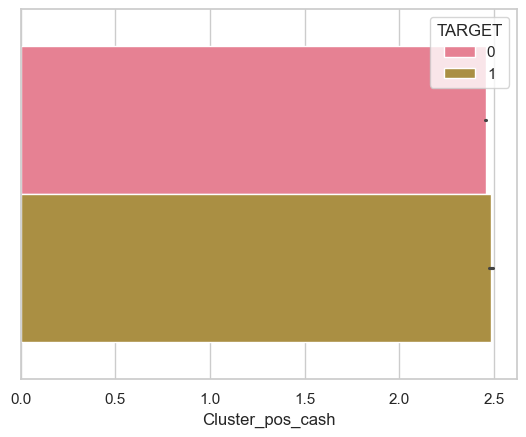

In [34]:
sns.barplot(data=app_pos_cash_feature_matrix, x='Cluster_pos_cash', hue='TARGET')
plt.show()

## Exporting

In [34]:
sorted_pos_cash_feature_matrix = pos_cash_feature_matrix[['SK_ID_PREV', 'SK_ID_CURR'] + feature_importance.head(10)['feature'].to_list()]
sorted_pos_cash_feature_matrix.to_csv(r'Archive\home-credit-default-risk\sorted_pos_cash_feature_matrix.csv')

In [35]:
# feature_importance[['Operation', 'Original_Feature']] = feature_importance['feature'].str.split('(', n=2, expand=True)

# feature_importance['Original_Feature'] = feature_importance['Original_Feature'].str.rstrip(')')
# feature_importance['Operation'] = feature_importance['Operation'].str.rstrip('(')


# feature_to_drop = duckdb.query(""" 
# SELECT Feature
# FROM (
#     SELECT 
#         *,
#         ROW_NUMBER() OVER (PARTITION BY Original_Feature ORDER BY Importance DESC) AS RowNumber
#     FROM feature_importance
#     WHERE Operation != 'STD' AND feature!='Duration'
#     ) A 
#     WHERE RowNumber != 1
# """ ).to_df()

# Installments Payments

In [36]:
installments_payments = help_tool.csv_download(r'Archive\home-credit-default-risk\installments_payments.csv')
#help_tool.first_look(installments_payments)

## Null values
Null values take less than 0%, 2905 rows. Payment day (DAYS_ENTRY_PAYMENT) is missing when payment amount is missing.

In [37]:
installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull() & installments_payments['AMT_PAYMENT'].notna()].shape

(0, 8)

Missing values are safe to drop, as the SK_ID_CURR can be found in non missing rows.

In [38]:
duckdb.query("""
             WITH 
             empty AS (
             SELECT DISTINCT SK_ID_CURR FROM installments_payments
             WHERE DAYS_ENTRY_PAYMENT IS NULL
             )

             ,not_empty AS (
             SELECT DISTINCT SK_ID_CURR FROM installments_payments
             WHERE DAYS_ENTRY_PAYMENT IS NOT NULL
             )

             SELECT *
             FROM empty
             LEFT JOIN not_empty
             ON empty.SK_ID_CURR = not_empty.SK_ID_CURR
             WHERE empty.SK_ID_CURR IS NULL
             """).to_df().shape

(0, 2)

In [39]:
installments_payments = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].notna() & installments_payments['AMT_PAYMENT'].notna()]

## EDA

In [40]:
# sns.scatterplot(data=installments_payments.sample(100000, random_state=42), x='AMT_PAYMENT', y='AMT_INSTALMENT')
# plt.show()

In [41]:
# sns.scatterplot(data=installments_payments.sample(100000, random_state=42), x='DAYS_INSTALMENT', y='DAYS_ENTRY_PAYMENT')
# plt.show()

In [42]:
# sns.scatterplot(data=installments_payments.sample(100000, random_state=42), x='NUM_INSTALMENT_VERSION', y='NUM_INSTALMENT_NUMBER')
# plt.show()

## Feature Engineering

In [43]:
installments_payments[['MISSED_DEADLINE_DAYS', 'MISSED_AMT_PAYMENT', 'CHANGE_INSTALMENT_NUMBER']] = duckdb.query("""
        SELECT 
            CAST((CAST(DAYS_ENTRY_PAYMENT AS INT) - CAST(DAYS_INSTALMENT AS INT)) AS INT) AS MISSED_DEADLINE_DAYS,
            CAST((CAST(AMT_PAYMENT AS INT) - CAST(AMT_INSTALMENT AS INT)) AS INT) AS MISSED_AMT_PAYMENT,
            CAST((CAST(NUM_INSTALMENT_VERSION AS INT) - CAST(NUM_INSTALMENT_NUMBER AS INT)) AS INT) AS CHANGE_INSTALMENT_NUMBER                                                                                  
        FROM installments_payments 
""").to_df()

## Previous Application and installments_payments

In [44]:
installments_payments_simplified = installments_payments[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates().reset_index(drop=True)

In [45]:
es = ft.EntitySet(id='installments_payments_data')

es = es.add_dataframe(dataframe_name='installments_payments_simplified',
                      dataframe=installments_payments_simplified,
                      index='SK_ID_PREV')

es = es.add_dataframe(dataframe_name='installments_payments',
                      dataframe=installments_payments.drop(columns=['DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT', 'SK_ID_CURR']),
                      make_index=True,
                      index='index')

es = es.add_relationship(parent_dataframe_name='installments_payments_simplified',
                         parent_column_name='SK_ID_PREV',
                         child_dataframe_name='installments_payments',
                         child_column_name='SK_ID_PREV')

installments_payments_feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='installments_payments_simplified',
                                      agg_primitives=['mean', 'sum', 'count', 'std', 'max', 'min']
                                      )


installments_payments_feature_matrix = installments_payments_feature_matrix.reset_index()
installments_payments_feature_matrix.shape

c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x0000014F98C2EFC0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function std at 0x0000014F98C2F100> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function max at 0x0000014F98C2E5C0> is currently using Ser

(997674, 38)

In [46]:
installments_payments_feature_matrix = duckdb.query("""  
  SELECT A.*, B.Duration
  FROM installments_payments_feature_matrix A 
  LEFT JOIN (
    SELECT SK_ID_PREV, MAX(DAYS_INSTALMENT) - MIN(DAYS_INSTALMENT) AS Duration
    FROM installments_payments
    GROUP BY SK_ID_PREV
    ) B ON A.SK_ID_PREV = B.SK_ID_PREV
  """).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [47]:
installments_payments_feature_matrix.drop(
    columns= help_tool.zero_variance_features(installments_payments_feature_matrix), 
    inplace = True
    )

In [48]:
installments_payments_feature_matrix.to_csv(r'Archive\home-credit-default-risk\installments_payments_feature_matrix.csv')

## Selecting featureswith Light XGB
### 1st run

In [49]:
app_installments_payments_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM installments_payments_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

7% of target is positive

In [50]:
app_installments_payments_feature_matrix['TARGET'].value_counts() / app_installments_payments_feature_matrix['TARGET'].count()

TARGET
0    0.924404
1    0.075596
Name: count, dtype: float64

In [51]:
y = app_installments_payments_feature_matrix['TARGET']
X = app_installments_payments_feature_matrix.drop(columns=['TARGET', 'SK_ID_CURR'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [52]:
def features_to_drop(df):
    # Step 1: Drop unnecessary columns
    filtered_matrix = df

    # Step 2: Compute the correlation matrix
    correlation_matrix = filtered_matrix.corr()

    # Step 3: Identify pairs of features with correlation greater than 0.9
    high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
    high_corr_pairs = high_corr_pairs[(high_corr_pairs < 1.0) & (high_corr_pairs >= 0.9)]

    # Convert the series to a DataFrame for better readability
    high_corr_pairs_df = high_corr_pairs.reset_index()
    high_corr_pairs_df.columns = ['Feature1', 'Feature2', 'Correlation']

    # Step 4: Rank features based on feature importance
    # Assuming feature_importance is a DataFrame with 'feature' and 'importance' columns
    # Join importance values with the feature pairs
    high_corr_pairs_df = high_corr_pairs_df.merge(
        feature_importance, left_on='Feature1', right_on='feature').rename(columns={'importance': 'Importance1'})
    high_corr_pairs_df = high_corr_pairs_df.merge(
        feature_importance, left_on='Feature2', right_on='feature').rename(columns={'importance': 'Importance2'})

    # Drop the extra 'feature' columns from the merges
    high_corr_pairs_df = high_corr_pairs_df.drop(columns=['feature_x', 'feature_y'])

    # Step 5: Determine which feature to drop based on lower importance
    high_corr_pairs_df['Feature_to_Drop'] = np.where(
        high_corr_pairs_df['Importance1'] < high_corr_pairs_df['Importance2'], 
        high_corr_pairs_df['Feature1'], 
        high_corr_pairs_df['Feature2']
    )

    # Identify unique features to drop
    features_to_drop = high_corr_pairs_df['Feature_to_Drop'].unique()
    return features_to_drop


In [53]:
drop_list = features_to_drop(app_installments_payments_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']))

In [54]:
app_installments_payments_feature_matrix.drop(columns=drop_list, inplace=True)

### 2nd Run

In [55]:
y = app_installments_payments_feature_matrix['TARGET']
X = app_installments_payments_feature_matrix.drop(columns=['TARGET', 'SK_ID_CURR', 'SK_ID_PREV'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [56]:
# app_installments_payments_feature_matrix_filtered = app_installments_payments_feature_matrix[['SK_ID_PREV', 'TARGET'] + feature_importance.head(15)['feature'].to_list()]

## Exporting

In [57]:
sorted_installments_payments_feature_matrix = installments_payments_feature_matrix[['SK_ID_PREV', 'SK_ID_CURR'] + feature_importance.head(10)['feature'].to_list()]
sorted_installments_payments_feature_matrix.to_csv(r'Archive\home-credit-default-risk\sorted_installments_payments_feature_matrix.csv')

# Credit_Card_Balance

In [58]:
credit_card_balance = help_tool.csv_download(r'Archive\home-credit-default-risk\credit_card_balance.csv')
#help_tool.first_look(credit_card_balance)

## Null values
AMT_DRAWINGS_ATM_CURRENT has the same NaN values as the rest of AMT_DRAWINGS columns. 

Drawing features for places have missing values, where the total amount is 0.

In [59]:
credit_card_balance[credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].isna()].filter(regex='.*_DRAWINGS_', axis=1).describe()

,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT
count,0.0,749816.0,0.0,0.0,0.0,749816.0,0.0,0.0
mean,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
min,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
25%,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
50%,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
75%,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
max,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN


Features AMT_INST_MIN_REGULARITY and CNT_INSTALMENT_MATURE_CUM are depected as NaN when the account was recently activated.

In [60]:
credit_card_balance[credit_card_balance['AMT_INST_MIN_REGULARITY'].isna() & credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].notna()].shape

(0, 23)

In [61]:
for feature in credit_card_balance.filter(regex='.*CURRENT', axis=1).columns.to_list():
    credit_card_balance.loc[(credit_card_balance['AMT_DRAWINGS_CURRENT'] == 0) & credit_card_balance[feature].isna(), feature] = 0

credit_card_balance.loc[(credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] == 0) & credit_card_balance['AMT_PAYMENT_CURRENT'].isna(), 'AMT_PAYMENT_CURRENT'] = 0

for feature in ['AMT_INST_MIN_REGULARITY', 'CNT_INSTALMENT_MATURE_CUM']:
    credit_card_balance.loc[~credit_card_balance['NAME_CONTRACT_STATUS'].isin(['Demand', 'Active']) & credit_card_balance[feature].isna(), feature] = 0

## EDA

In [62]:
# sns.scatterplot(data=credit_card_balance.sample(100000, random_state=42),
#                 x='CNT_INSTALMENT_MATURE_CUM',
#                 y='AMT_CREDIT_LIMIT_ACTUAL'
#                 )
# plt.show()

In [63]:
# sns.scatterplot(data=credit_card_balance.sample(100000, random_state=42),
#                 x='CNT_INSTALMENT_MATURE_CUM',
#                 y='AMT_BALANCE'
#                 )
# plt.show()

In [64]:
# sns.scatterplot(data=credit_card_balance.sample(100000, random_state=42),
#                 x='CNT_INSTALMENT_MATURE_CUM',
#                 y='AMT_INST_MIN_REGULARITY'
#                 )
# plt.show()

## Feature Engineering

In [65]:
credit_card_balance['CARD_ACTIVITY'] = credit_card_balance['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_card_activity)
credit_card_balance['RISK_PROFILE'] = credit_card_balance['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_risk_profile)

credit_card_balance.drop(columns='NAME_CONTRACT_STATUS', inplace=True)

In [66]:
credit_card_balance['FLAG_ZERO_AMT_BALANCE'] = np.where(credit_card_balance['AMT_BALANCE'] == 0, 1, 0)
credit_card_balance['FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL'] = np.where(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] == 0, 1, 0)

In [67]:
credit_card_balance[[
    'RATE_UTILIZATION_LIMIT', 'RATE_INSTALMENT_BALANCE', 'RATE_INST_MIN', 'RATIO_DPD', 
    'RATE_DRAWINGS_CURRENT', 'RATE_DRAWINGS_ATM_CURRENT', 'RATE_DRAWINGS_OTHER_CURRENT', 'RATE_DRAWINGS_POS_CURRENT',
    'RATE_RECEIVABLE', 'RATE_RECEIVABLE_PRINCIPAL', 'RATE_PAYMENT_CURRENT', 'RATE_RECEIVABLE_VS_PAYMENT'
                     ]] = duckdb.query("""
            SELECT 
            
             (AMT_CREDIT_LIMIT_ACTUAL / AMT_BALANCE) AS RATE_UTILIZATION_LIMIT,

             (CNT_INSTALMENT_MATURE_CUM / AMT_BALANCE) AS RATE_INSTALMENT_BALANCE,
             (CNT_INSTALMENT_MATURE_CUM / AMT_INST_MIN_REGULARITY) AS RATE_INST_MIN,

             (SK_DPD / SK_DPD_DEF) AS RATIO_DPD,

             (AMT_DRAWINGS_CURRENT / CNT_DRAWINGS_CURRENT) AS RATE_DRAWINGS_CURRENT,
             (AMT_DRAWINGS_ATM_CURRENT / CNT_DRAWINGS_ATM_CURRENT) AS RATE_DRAWINGS_ATM_CURRENT,
             (AMT_DRAWINGS_OTHER_CURRENT / CNT_DRAWINGS_OTHER_CURRENT) AS RATE_DRAWINGS_OTHER_CURRENT,
             (AMT_DRAWINGS_POS_CURRENT / CNT_DRAWINGS_POS_CURRENT) AS RATE_DRAWINGS_POS_CURRENT,

             (AMT_TOTAL_RECEIVABLE / AMT_RECIVABLE) AS RATE_RECEIVABLE,
             (AMT_RECEIVABLE_PRINCIPAL / AMT_RECIVABLE) AS RATE_RECEIVABLE_PRINCIPAL,

             (AMT_PAYMENT_TOTAL_CURRENT / AMT_PAYMENT_CURRENT) AS RATE_PAYMENT_CURRENT,

             (AMT_PAYMENT_CURRENT / AMT_RECIVABLE) AS RATE_RECEIVABLE_VS_PAYMENT       

            FROM credit_card_balance

""").to_df()

## Previous Application and credit_card_balance

In [68]:
credit_card_balance_simplified = credit_card_balance[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates().reset_index(drop=True)

In [69]:
es = ft.EntitySet(id='credit_card_balance_data')

es = es.add_dataframe(dataframe_name='credit_card_balance_simplified',
                      dataframe=credit_card_balance_simplified,
                      index='SK_ID_PREV')

es = es.add_dataframe(dataframe_name='credit_card_balance',
                      dataframe=credit_card_balance.drop(columns=['MONTHS_BALANCE', 'SK_ID_CURR']),
                      make_index=True,
                      index='index')

es = es.add_relationship(parent_dataframe_name='credit_card_balance_simplified',
                         parent_column_name='SK_ID_PREV',
                         child_dataframe_name='credit_card_balance',
                         child_column_name='SK_ID_PREV')

credit_card_balance_feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='credit_card_balance_simplified',
                                      agg_primitives=['mean', 'sum', 'count', 'std', 'max', 'min']
                                      )


credit_card_balance_feature_matrix = credit_card_balance_feature_matrix.reset_index()
credit_card_balance_feature_matrix.shape

c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function sum at 0x0000014F98C2DEE0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function std at 0x0000014F98C2F100> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x0000014F98C2EFC0> is currently using Serie

(104307, 178)

In [70]:
credit_card_balance_feature_matrix = duckdb.query("""  
  SELECT A.*, B.Duration
  FROM credit_card_balance_feature_matrix A 
  LEFT JOIN (
    SELECT SK_ID_PREV, MAX(MONTHS_BALANCE) - MIN(MONTHS_BALANCE) AS Duration
    FROM credit_card_balance
    GROUP BY SK_ID_PREV
    ) B ON A.SK_ID_PREV = B.SK_ID_PREV
  """).to_df()

In [71]:
credit_card_balance_feature_matrix.drop(
    columns= help_tool.zero_variance_features(credit_card_balance_feature_matrix), 
    inplace = True
    )

In [72]:
credit_card_balance_feature_matrix.to_csv(r'Archive\home-credit-default-risk\credit_card_balance_feature_matrix.csv')

## Selecting featureswith Light XGB
### 1st run

In [73]:
app_credit_card_balance_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM credit_card_balance_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

8% of target is postitive

In [74]:
app_credit_card_balance_feature_matrix['TARGET'].value_counts() / app_credit_card_balance_feature_matrix['TARGET'].count()

TARGET
0    0.91321
1    0.08679
Name: count, dtype: float64

In [75]:
y = app_credit_card_balance_feature_matrix['TARGET']
X = app_credit_card_balance_feature_matrix.drop(columns=['TARGET', 'SK_ID_CURR'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [76]:
drop_list = features_to_drop(app_credit_card_balance_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']))
drop_list

array(['MIN(credit_card_balance.AMT_TOTAL_RECEIVABLE)',
       'STD(credit_card_balance.AMT_TOTAL_RECEIVABLE)',
       'MEAN(credit_card_balance.AMT_TOTAL_RECEIVABLE)',
       'MAX(credit_card_balance.AMT_TOTAL_RECEIVABLE)', 'Duration',
       'SUM(credit_card_balance.AMT_TOTAL_RECEIVABLE)',
       'MEAN(credit_card_balance.AMT_RECIVABLE)',
       'SUM(credit_card_balance.AMT_RECIVABLE)',
       'STD(credit_card_balance.AMT_BALANCE)',
       'STD(credit_card_balance.AMT_RECIVABLE)',
       'MAX(credit_card_balance.AMT_RECIVABLE)',
       'MEAN(credit_card_balance.AMT_RECEIVABLE_PRINCIPAL)',
       'STD(credit_card_balance.AMT_RECEIVABLE_PRINCIPAL)',
       'SUM(credit_card_balance.AMT_RECEIVABLE_PRINCIPAL)',
       'MIN(credit_card_balance.AMT_RECEIVABLE_PRINCIPAL)',
       'MAX(credit_card_balance.AMT_BALANCE)',
       'MAX(credit_card_balance.AMT_PAYMENT_TOTAL_CURRENT)',
       'STD(credit_card_balance.AMT_PAYMENT_CURRENT)',
       'MIN(credit_card_balance.AMT_RECIVABLE)',
       'SU

In [77]:
app_credit_card_balance_feature_matrix.drop(columns=drop_list, inplace=True)

### 2nd Run

In [78]:
y = app_credit_card_balance_feature_matrix['TARGET']
X = app_credit_card_balance_feature_matrix.drop(columns=['TARGET', 'SK_ID_PREV'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

## Exporting

In [79]:
sorted_credit_card_balance_feature_matrix = credit_card_balance_feature_matrix[['SK_ID_PREV', 'SK_ID_CURR'] + feature_importance.head(10)['feature'].to_list()]
sorted_credit_card_balance_feature_matrix.to_csv(r'Archive\home-credit-default-risk\sorted_credit_card_balance_feature_matrix.csv')